##### сеть не удаляет(не блокирует) узел если он перегружен, просто уменьшается нагрузка
##### 
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,54
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.34;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    #{"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

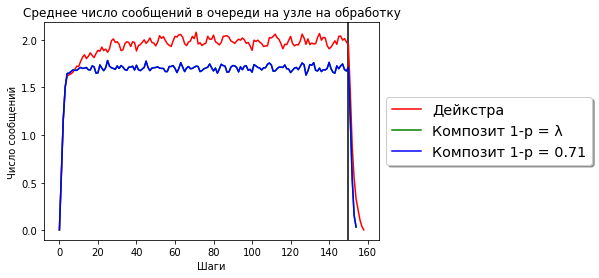

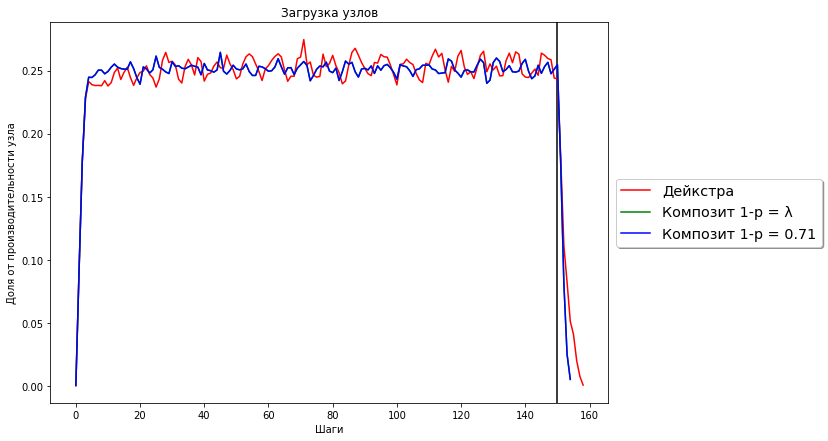

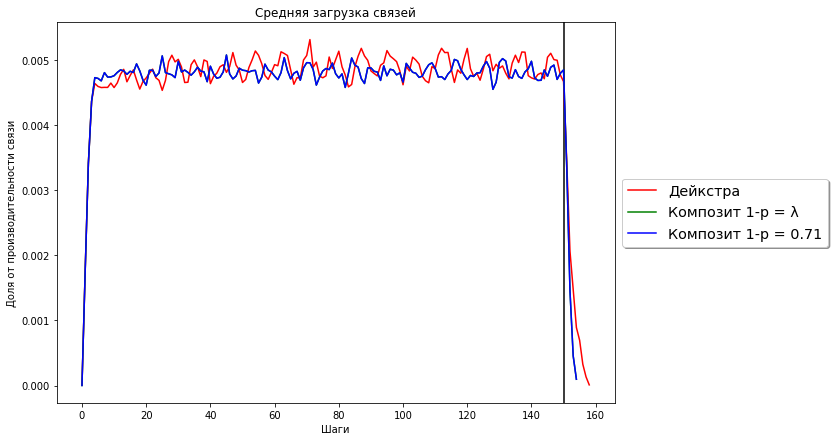

Доставлено 15001 Потеряно 0.0000% -Дейкстра
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = λ
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = 0.71


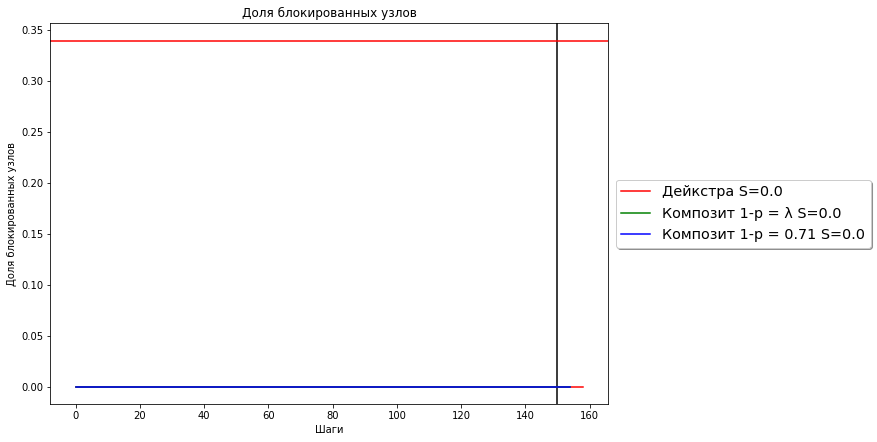

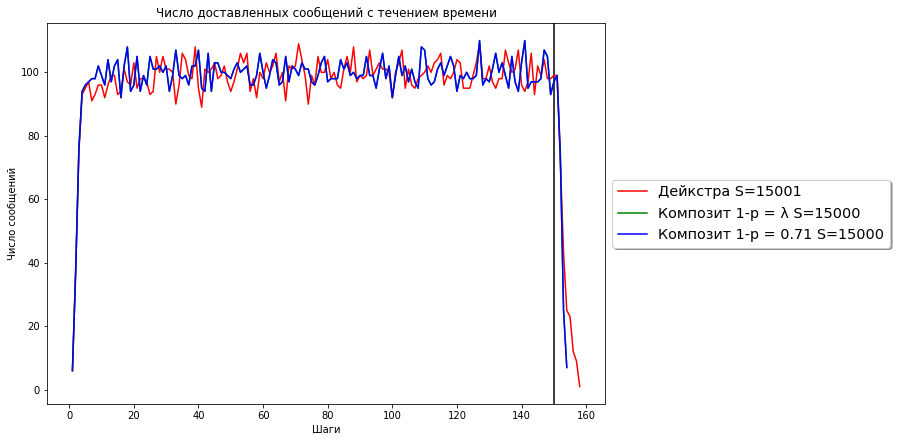

In [2]:
log_tags = [
 {"tag":  "63eda112-0d9a-4a01-aecd-76e9047e4ccf", "label": "Дейкстра", "color": "red"},
 #{"tag":  "66872dd3-aad2-4a47-ad59-4de52ed29940", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "9ef74177-dbb5-4b5a-87e6-23f81782d3b9", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "b1ad8b4c-77cf-486e-be00-b0faef51ee1f", "label": "Композит 1-p = 0.71", "color": "blue"},
    #  magenta red green black
]
      
quantity = 100;                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

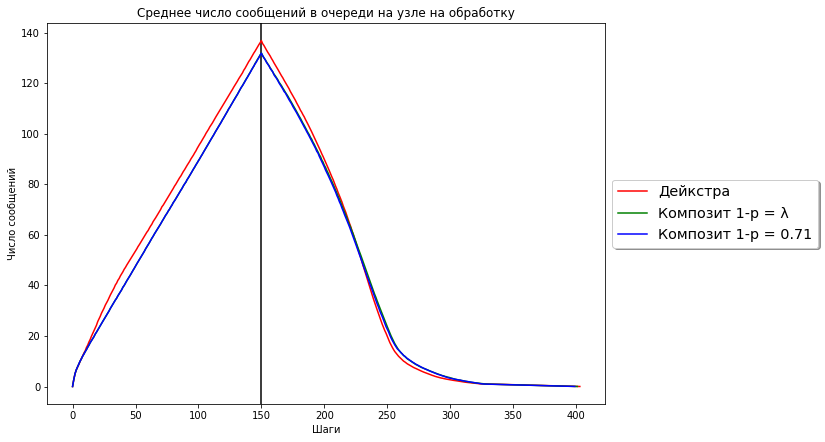

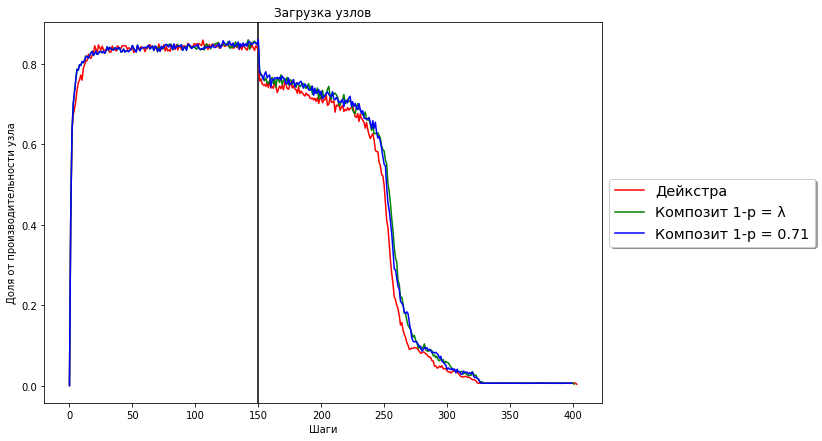

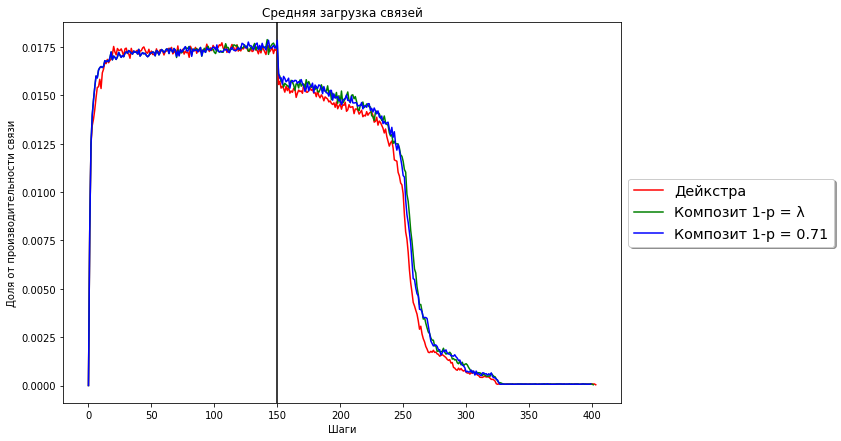

Доставлено 75001 Потеряно 0.0000% -Дейкстра
Доставлено 75000 Потеряно 0.0013% -Композит 1-p = λ
Доставлено 75000 Потеряно 0.0013% -Композит 1-p = 0.71


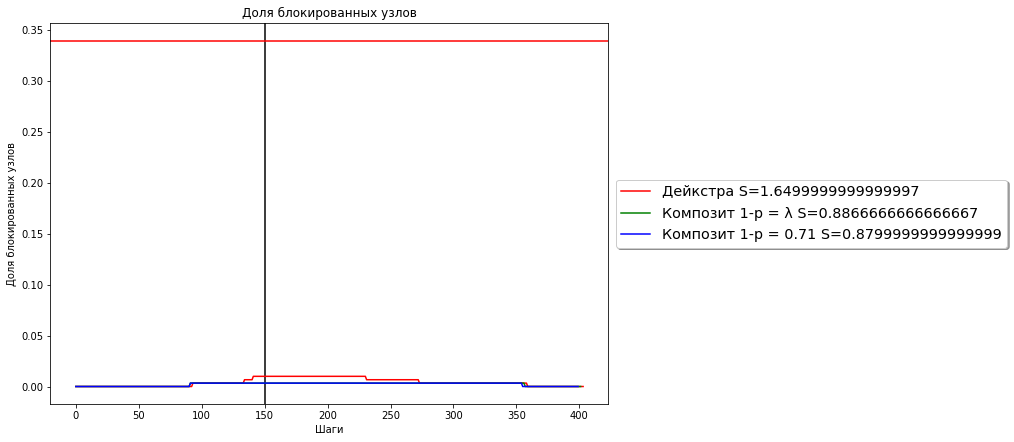

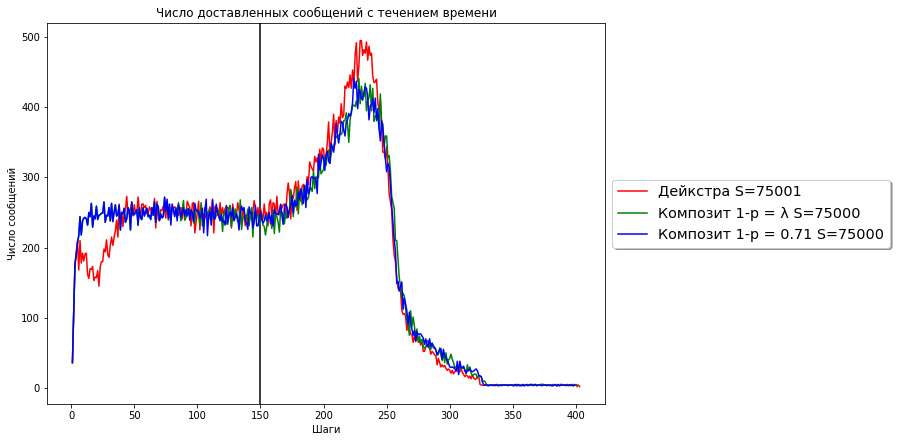

In [3]:
log_tags = [
 {"tag":  "5e272572-9aa8-413c-9566-706764ee6d4d", "label": "Дейкстра", "color": "red"},
 #{"tag":  "d4757e03-f4de-4e75-b736-821b544dfe17", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "d43c2530-b7ee-41ad-92f1-d44577e3eaf0", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "2c749e09-eb32-4527-b750-155a4385fa47", "label": "Композит 1-p = 0.71", "color": "blue"},
]
quantity = 500; 
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

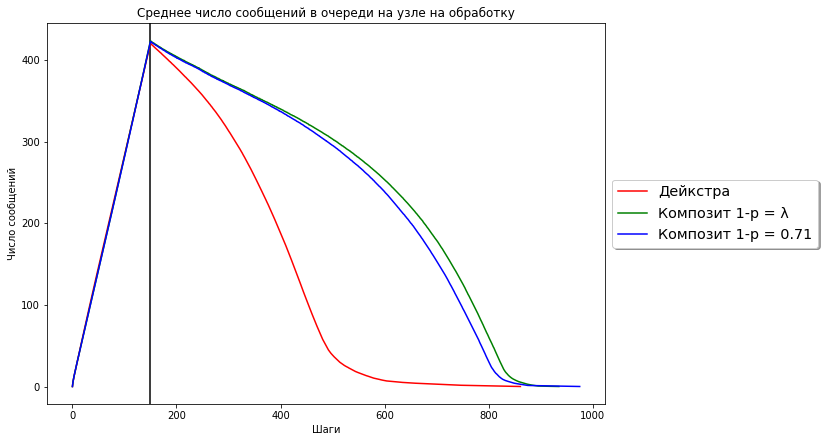

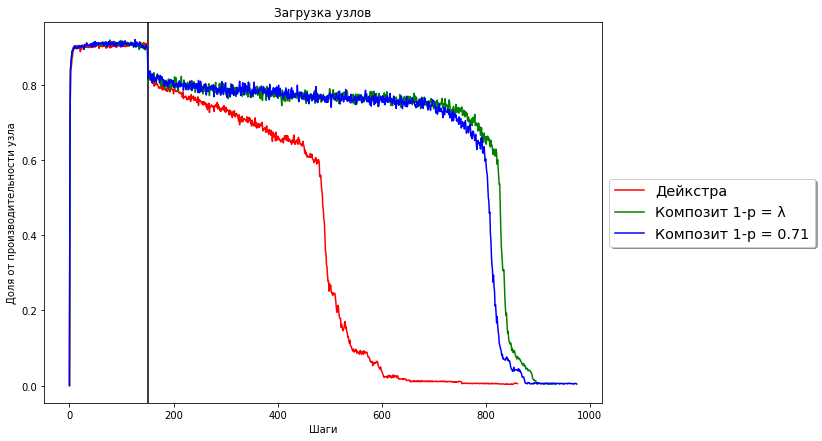

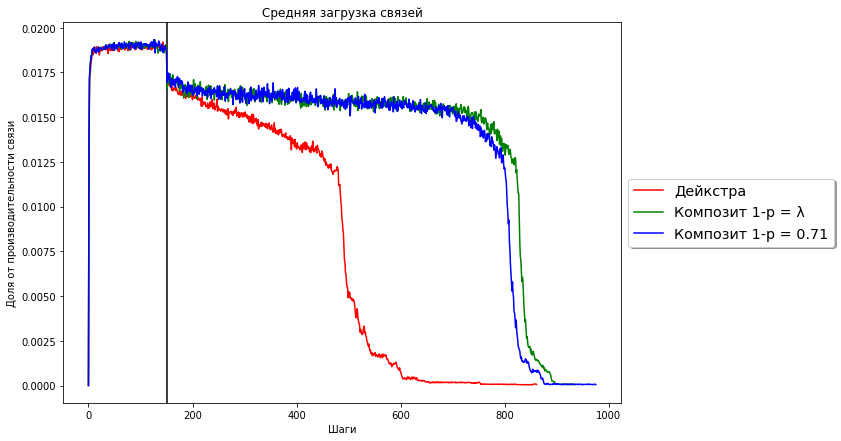

Доставлено 150001 Потеряно 0.0000% -Дейкстра
Доставлено 150000 Потеряно 0.0007% -Композит 1-p = λ
Доставлено 150000 Потеряно 0.0007% -Композит 1-p = 0.71


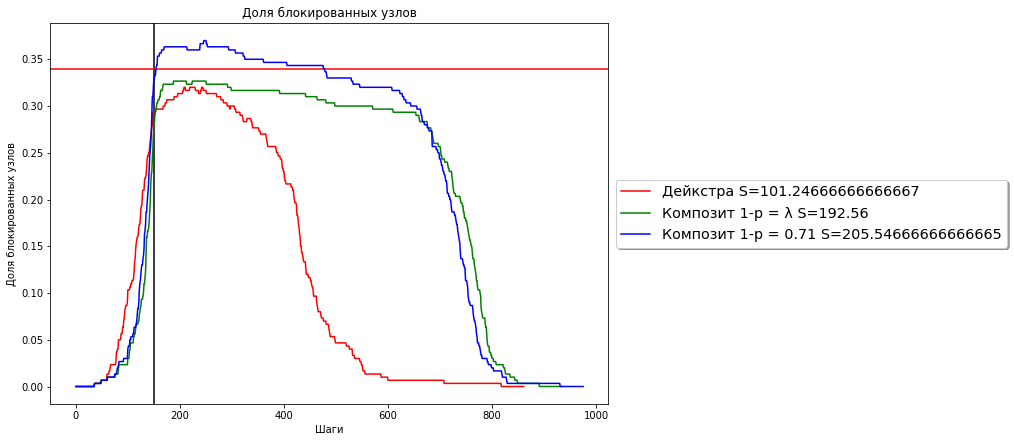

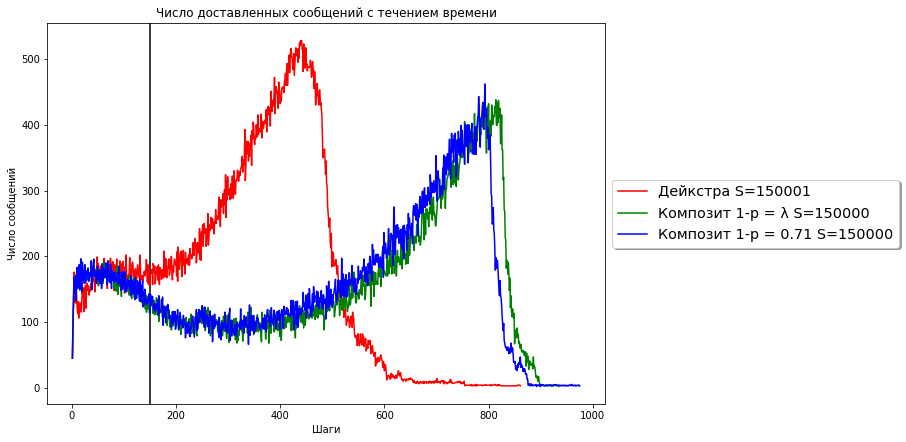

In [4]:
log_tags = [
 {"tag":  "5f5cda11-67d0-4a30-bab7-7dd03ca0166f", "label": "Дейкстра", "color": "red"},
 #{"tag":  "8b06eba0-5d75-426c-98b4-25cdfe9a26fc", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "89c8ff7e-3886-41ae-95b1-12a1735a82cb", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "95c7b121-0139-43ad-a19a-ac21b6930369", "label": "Композит 1-p = 0.71", "color": "blue"},
]
quantity = 1000; 
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

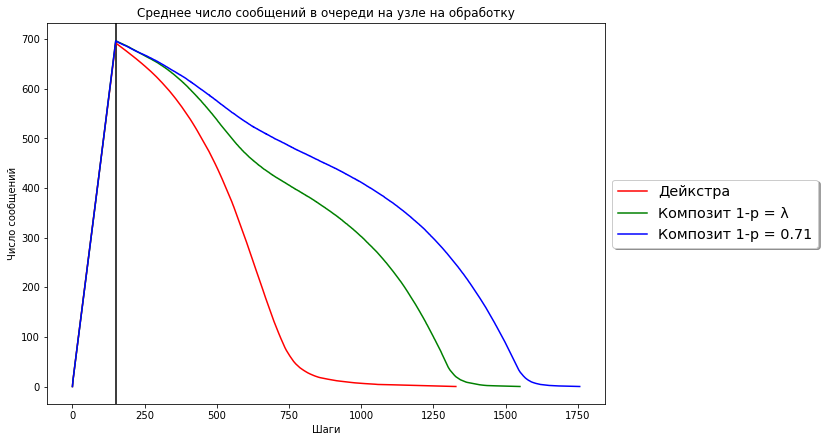

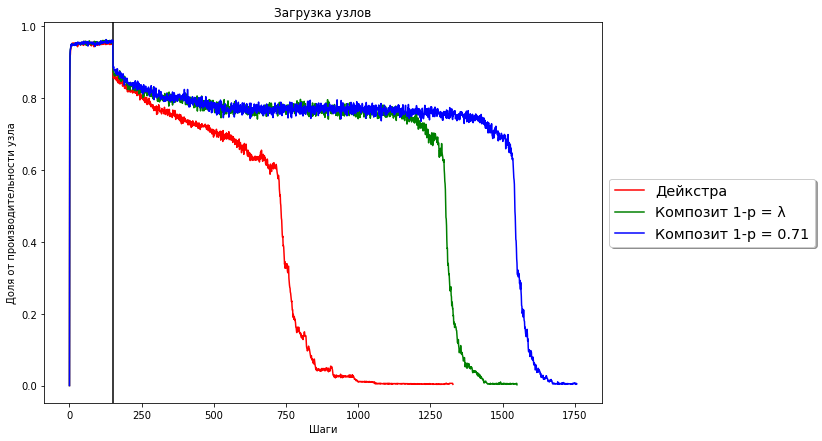

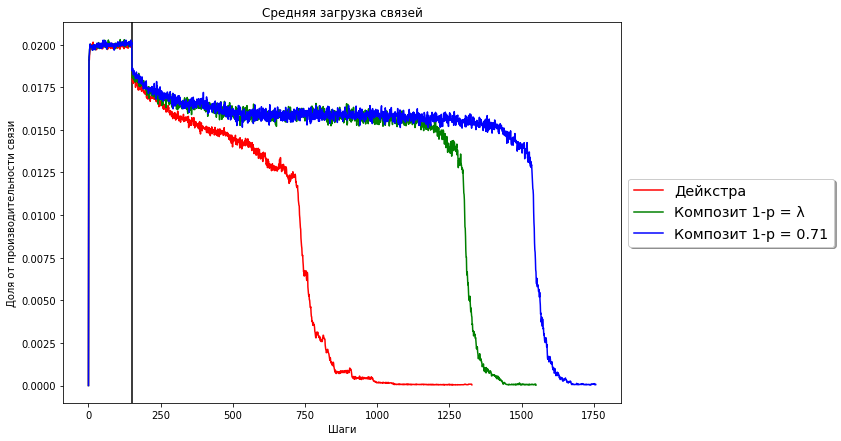

Доставлено 225001 Потеряно 0.0000% -Дейкстра
Доставлено 225000 Потеряно 0.0004% -Композит 1-p = λ
Доставлено 225000 Потеряно 0.0004% -Композит 1-p = 0.71


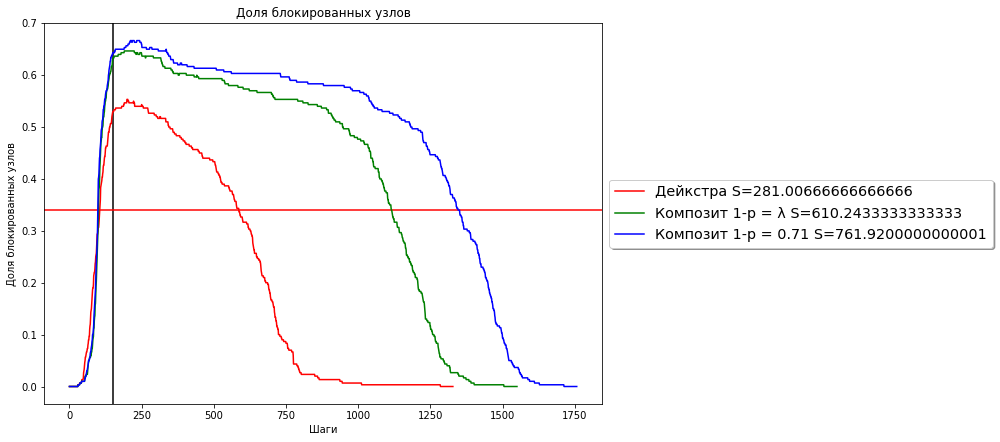

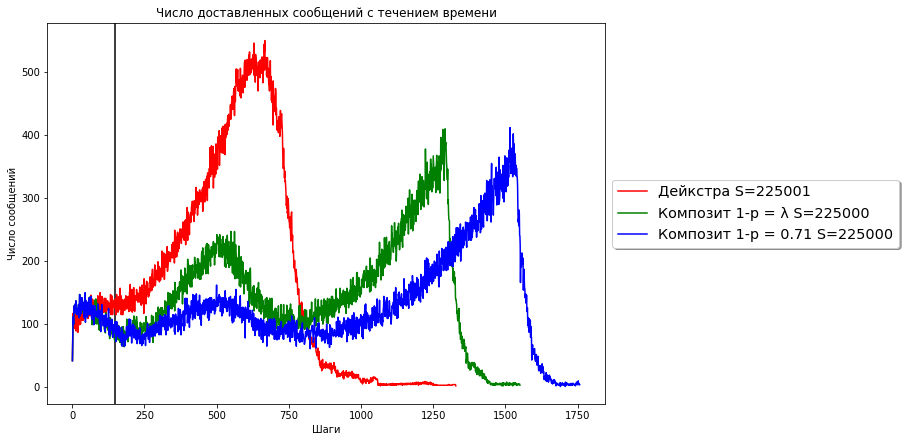

In [5]:
log_tags = [
 {"tag":  "79d10bda-30a8-444a-898f-8f9e924e57a9", "label": "Дейкстра", "color": "red"},
 #{"tag":  "e0ca3ab2-a902-4b06-96b9-db892dc1bc99", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "2ee1b896-a19a-4f63-96bf-b80186145109", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "b94d0c81-e0e8-4b9d-ade3-a2b2306b11c9", "label": "Композит 1-p = 0.71", "color": "blue"},
]
quantity = 1500; 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 45001 Потеряно 0.0000% -Дейкстра
Доставлено 45000 Потеряно 0.0022% -Композит 1-p = λ
Доставлено 45000 Потеряно 0.0022% -Композит 1-p = 0.71


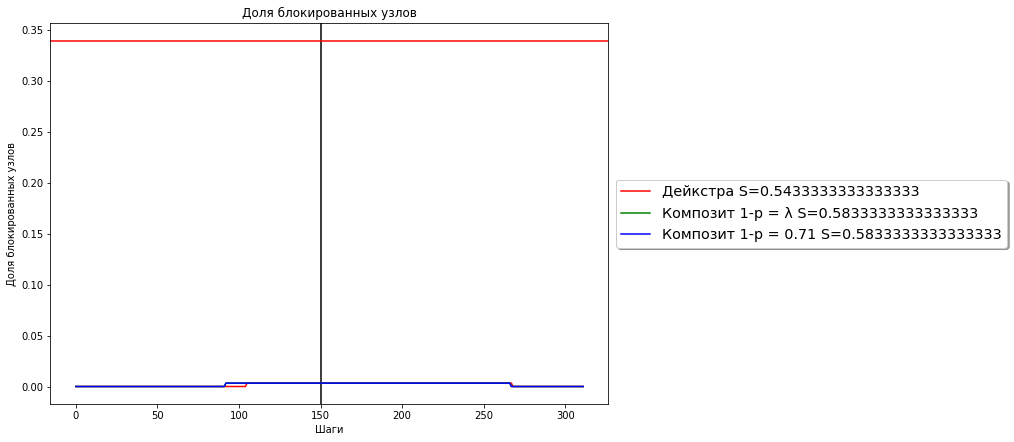

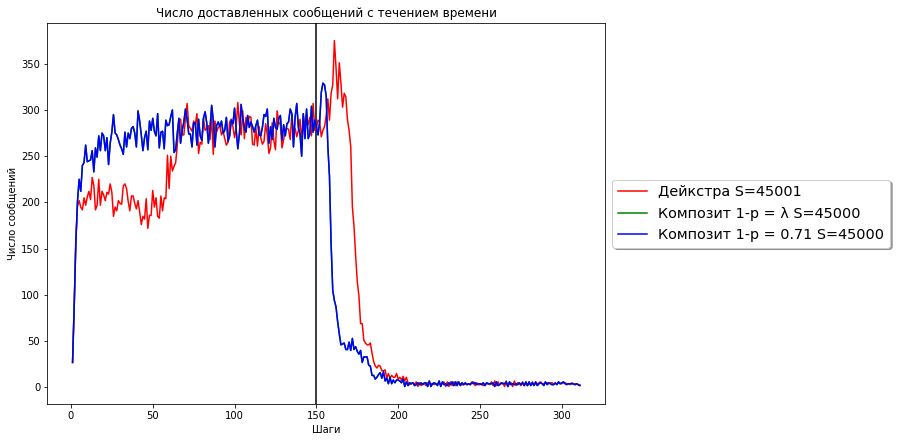

Доставлено 105001 Потеряно 0.0000% -Дейкстра
Доставлено 105000 Потеряно 0.0010% -Композит 1-p = λ
Доставлено 105000 Потеряно 0.0010% -Композит 1-p = 0.71


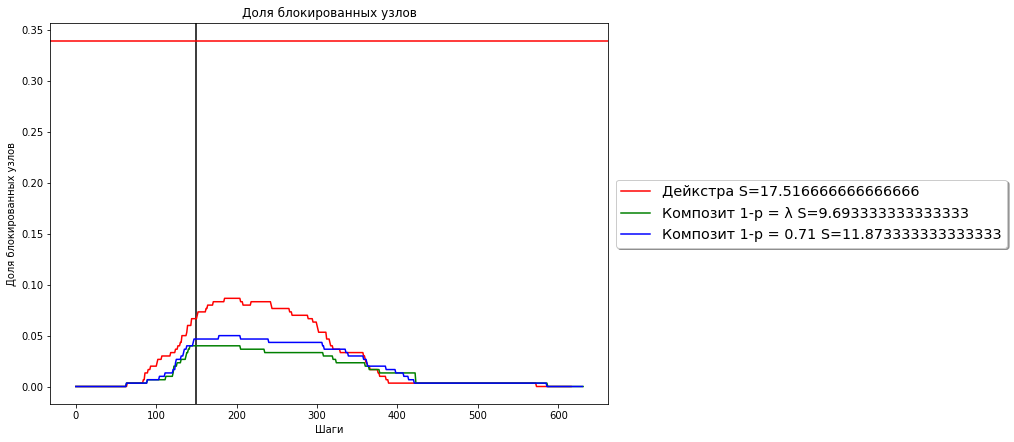

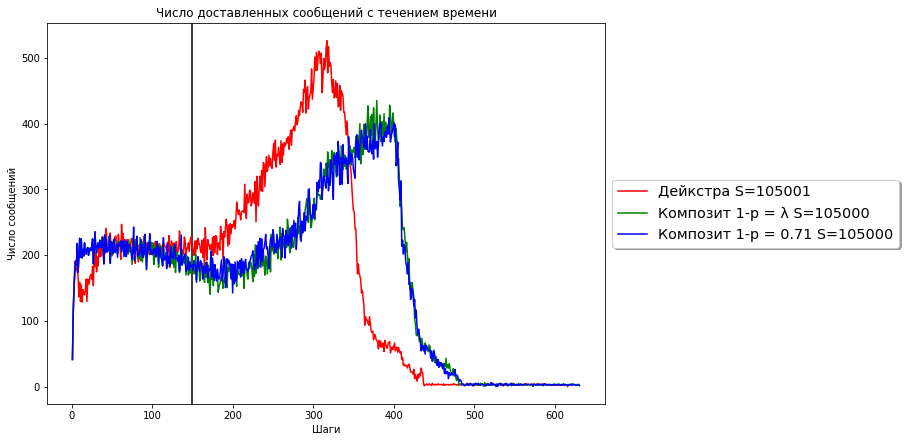

Доставлено 135001 Потеряно 0.0000% -Дейкстра
Доставлено 135000 Потеряно 0.0007% -Композит 1-p = λ
Доставлено 135000 Потеряно 0.0007% -Композит 1-p = 0.71


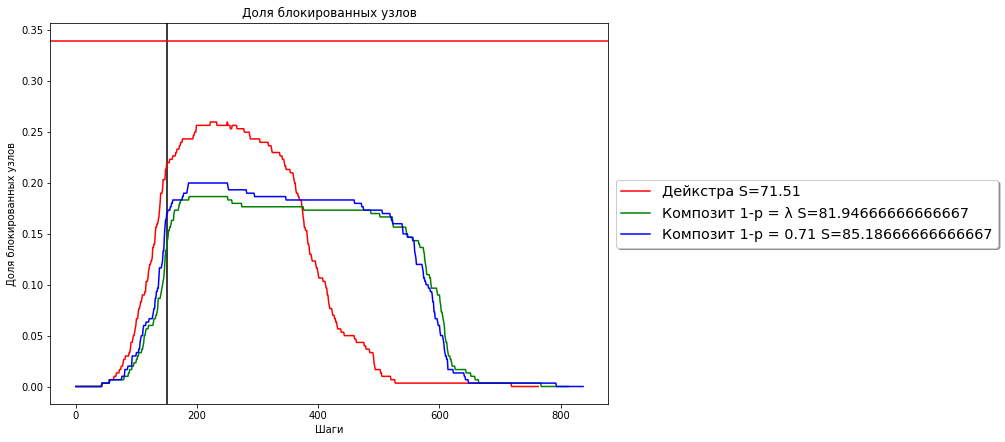

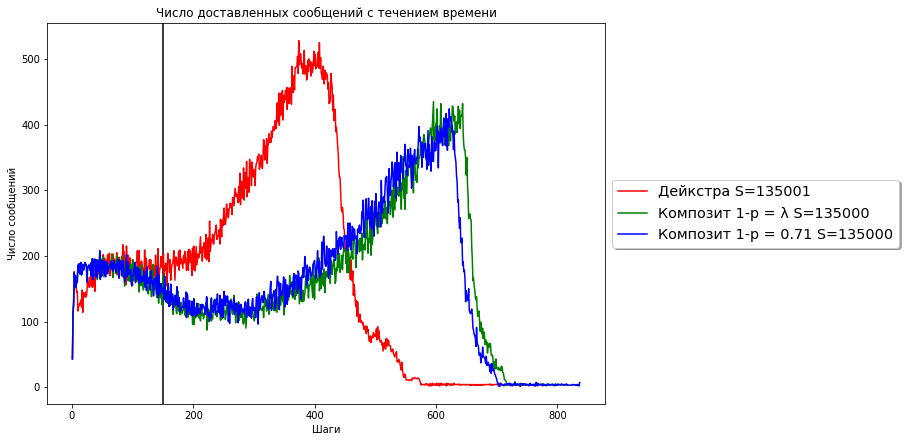

Доставлено 180001 Потеряно 0.0000% -Дейкстра
Доставлено 180000 Потеряно 0.0006% -Композит 1-p = λ
Доставлено 180000 Потеряно 0.0006% -Композит 1-p = 0.71


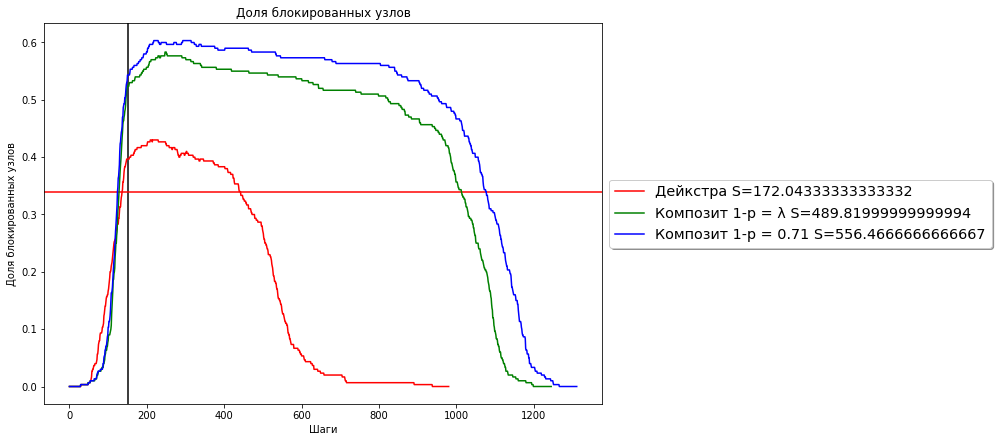

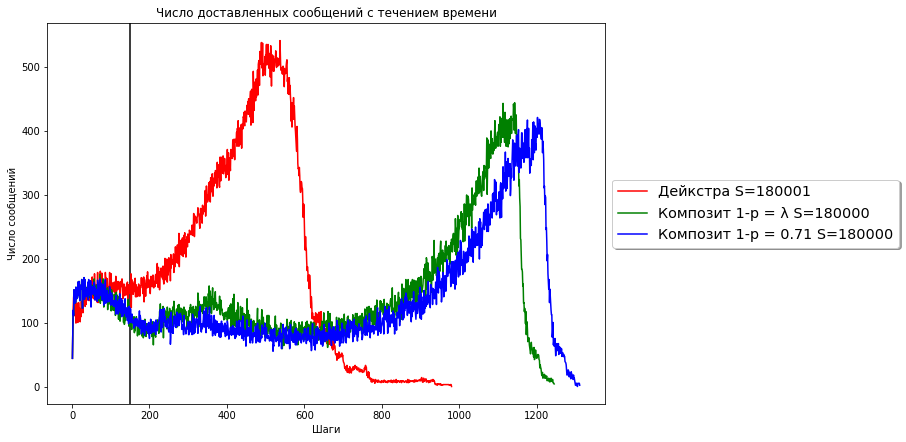

In [6]:
quantity = 300;  
log_tags = [
 {"tag":  "8cef132c-b295-4358-aec0-d2c3c50ebd4a", "label": "Дейкстра", "color": "red"},
 {"tag":  "a0b78ef8-2eff-4560-b342-293782729a94", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "f30b68de-c305-4a6c-be48-1741bae4ab5f", "label": "Композит 1-p = 0.71", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 700;  
log_tags = [
 {"tag":  "ecd39a87-1dd8-42d1-a83d-b6af7ae78497", "label": "Дейкстра", "color": "red"},
 {"tag":  "a6650a3c-e1ea-4371-83cd-ea18b0536f52", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "989ba66b-d9b9-4a32-8aa0-8d6ce23a0ac3", "label": "Композит 1-p = 0.71", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 900;  
log_tags = [
 {"tag":  "0e6f8660-a820-4e5e-a0e4-82424f852b9e", "label": "Дейкстра", "color": "red"},
 {"tag":  "70154803-d33d-4535-8e14-62d6bdd599ff", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "19fd6c0d-601c-425d-957c-20a9fdf08787", "label": "Композит 1-p = 0.71", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 1200;  
log_tags = [
 {"tag":  "e32e1bd5-7c4b-4466-9dc7-f439b74dd90e", "label": "Дейкстра", "color": "red"},
 {"tag":  "8ebc3d9a-df84-4778-bcd4-fc231b2c06fa", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "6334aba8-b517-41b2-a98e-3adeaf2d3420", "label": "Композит 1-p = 0.71", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

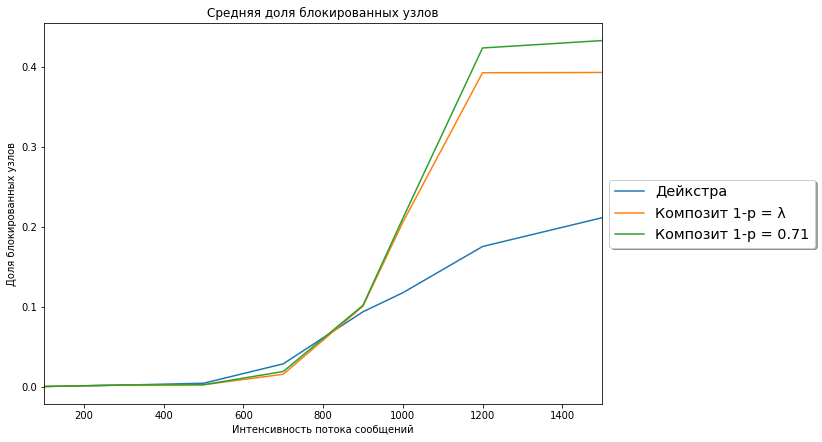

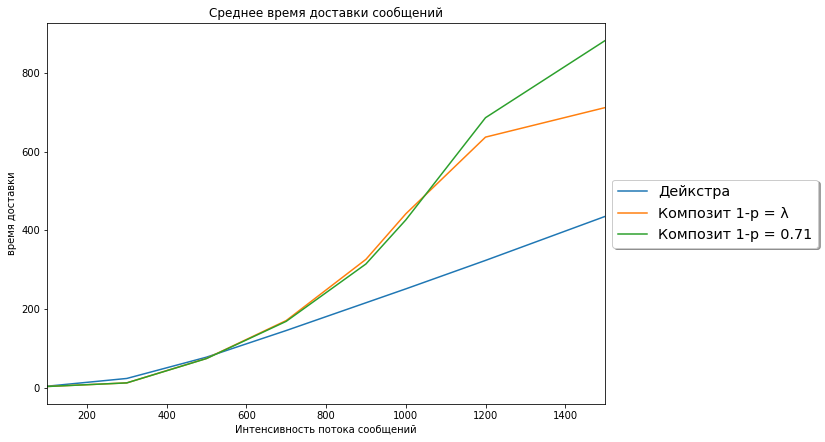

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

Дейкстра               0.079011
Композит 1-p = λ       0.139047
Композит 1-p = 0.71    0.149085

Дейкстра               0.000000
Композит 1-p = λ       0.001698
Композит 1-p = 0.71    0.001698

Дейкстра               184.604289
Композит 1-p = λ       297.325705
Композит 1-p = 0.71    321.111831
